In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from fastai.metrics import *

import matplotlib.pyplot as plt
import csv
from collections import defaultdict, namedtuple
import os
import shutil

import pandas as pd

from sklearn.metrics import confusion_matrix

In [ ]:
# Download and unpack the training set and the test set

! wget http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Training_Images.zip -P data
! wget http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Test_Images.zip -P data
! wget http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Test_GT.zip -P data
! unzip data/GTSRB_Final_Training_Images.zip -d data
! unzip data/GTSRB_Final_Test_Images.zip -d data
! unzip data/GTSRB_Final_Test_GT.zip -d data

# Move the test set to data/test

! mkdir data/test
! mv data/GTSRB/Final_Test/Images/*.ppm data/test

# Download class names
! wget https://raw.githubusercontent.com/georgesung/traffic_sign_classification_german/master/signnames.csv -P data

In [4]:
Annotation = namedtuple('Annotation', ['filename', 'label'])
def read_annotations(filename):
    annotations = []
    
    with open(filename) as f:
        reader = csv.reader(f, delimiter=';')
        next(reader) # skip header

        # loop over all images in current annotations file
        for row in reader:
            filename = row[0] # filename is in the 0th column
            label = int(row[7]) # label is in the 7th column
            annotations.append(Annotation(filename, label))
            
    return annotations

In [5]:
def load_training_annotations(source_path):
    annotations = []
    for c in range(0,43):
        filename = os.path.join(source_path, format(c, '05d'), 'GT-' + format(c, '05d') + '.csv')
        annotations.extend(read_annotations(filename))
    return annotations

def copy_files(label, filenames, source, destination, move=False):
    func = os.rename if move else shutil.copyfile
    
    label_path = os.path.join(destination, str(label))
    if not os.path.exists(label_path):
        os.makedirs(label_path)
        
    for filename in filenames:
        destination_path = os.path.join(label_path, filename)
        if not os.path.exists(destination_path):
            func(os.path.join(source, format(label, '05d'), filename), destination_path)

def split_train_validation_sets(source_path, train_path, validation_path, all_path, validation_fraction=0.2):
    """
    Splits the GTSRB training set into training and validation sets.
    """
    
    if not os.path.exists(train_path):
        os.makedirs(train_path)
        
    if not os.path.exists(validation_path):
        os.makedirs(validation_path)
        
    if not os.path.exists(all_path):
        os.makedirs(all_path)
    
    annotations = load_training_annotations(source_path)
    filenames = defaultdict(list)
    for annotation in annotations:
        filenames[annotation.label].append(annotation.filename)

    for label, filenames in filenames.items():
        filenames = sorted(filenames)
        
        validation_size = int(len(filenames) // 30 * validation_fraction) * 30
        train_filenames = filenames[validation_size:]
        validation_filenames = filenames[:validation_size]
        
        copy_files(label, filenames, source_path, all_path, move=False)
        copy_files(label, train_filenames, source_path, train_path, move=True)
        copy_files(label, validation_filenames, source_path, validation_path, move=True)

In [6]:
path = 'data'
source_path = os.path.join(path, 'GTSRB/Final_Training/Images')
train_path = os.path.join(path, 'train')
validation_path = os.path.join(path, 'valid')
all_path = os.path.join(path, 'all')
validation_fraction = 0.2
split_train_validation_sets(source_path, train_path, validation_path, all_path, validation_fraction)

In [7]:
test_annotations = read_annotations('data/GT-final_test.csv')

# Exploratory analysis

In [8]:
classes = pd.read_csv('data/signnames.csv')
class_names = {}
for i, row in classes.iterrows():
    class_names[str(row[0])] = row[1]

In [1830]:
arch=resnet34
sz = 96
data = ImageClassifierData.from_paths(path, tfms=tfms_from_model(arch, sz), test_name='test')

augmentated training samples are shuffled


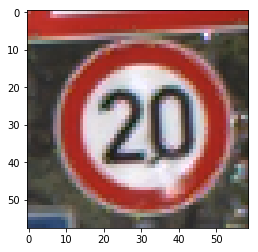

In [10]:
plt.imshow(load_img_id(data.val_ds, 1, path))
plt.show()

In [11]:
y = data.trn_ds.y

In [12]:
print(y[:10])

[0 0 0 0 0 0 0 0 0 0]


In [13]:
from collections import Counter

label_counts = Counter(y).most_common()
for l, c in label_counts:
    print(c, '\t', data.classes[l], '\t', class_names[data.classes[l]])

1800 	 1 	 Speed limit (30km/h)
1800 	 2 	 Speed limit (50km/h)
1740 	 13 	 Yield
1680 	 12 	 Priority road
1680 	 38 	 Keep right
1620 	 10 	 No passing for vechiles over 3.5 metric tons
1590 	 4 	 Speed limit (70km/h)
1500 	 5 	 Speed limit (80km/h)
1200 	 25 	 Road work
1200 	 9 	 No passing
1170 	 7 	 Speed limit (100km/h)
1140 	 3 	 Speed limit (60km/h)
1140 	 8 	 Speed limit (120km/h)
1080 	 11 	 Right-of-way at the next intersection
960 	 18 	 General caution
960 	 35 	 Ahead only
900 	 17 	 No entry
630 	 14 	 Stop
630 	 31 	 Wild animals crossing
569 	 33 	 Turn right ahead
510 	 15 	 No vechiles
480 	 26 	 Traffic signals
450 	 28 	 Children crossing
420 	 23 	 Slippery road
360 	 16 	 Vechiles over 3.5 metric tons prohibited
360 	 30 	 Beware of ice/snow
360 	 34 	 Turn left ahead
360 	 6 	 End of speed limit (80km/h)
330 	 22 	 Bumpy road
330 	 36 	 Go straight or right
300 	 20 	 Dangerous curve to the right
300 	 40 	 Roundabout mandatory
270 	 21 	 Double curve
240 	 24 

0 Speed limit (20km/h)


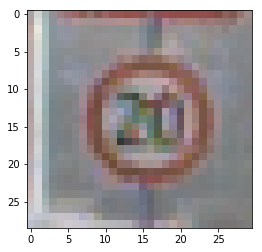

1 Speed limit (30km/h)


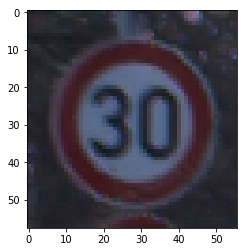

2 Speed limit (50km/h)


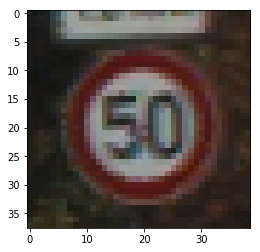

3 Speed limit (60km/h)


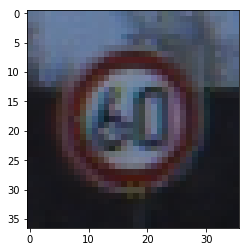

4 Speed limit (70km/h)


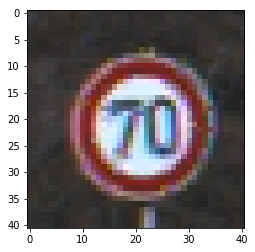

5 Speed limit (80km/h)


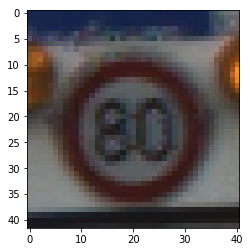

6 End of speed limit (80km/h)


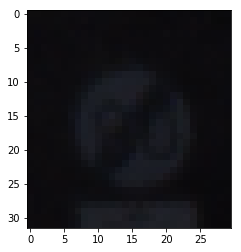

7 Speed limit (100km/h)


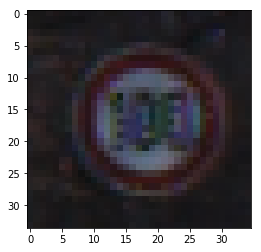

8 Speed limit (120km/h)


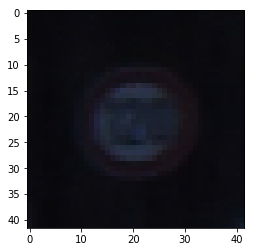

9 No passing


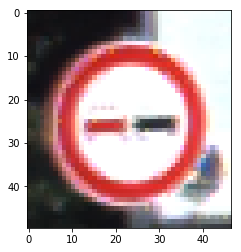

10 No passing for vechiles over 3.5 metric tons


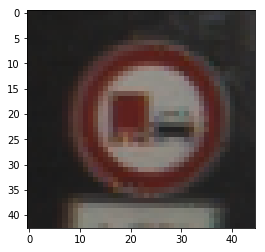

11 Right-of-way at the next intersection


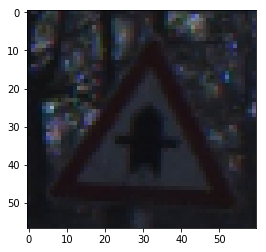

12 Priority road


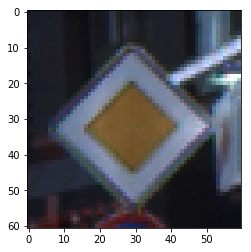

13 Yield


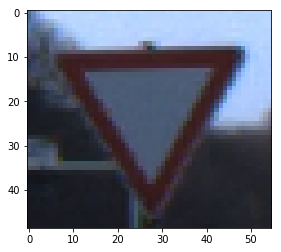

14 Stop


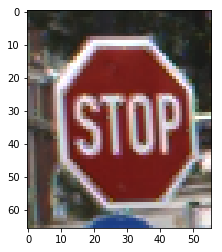

15 No vechiles


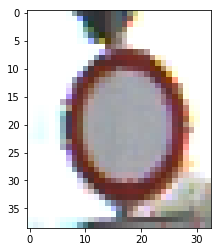

16 Vechiles over 3.5 metric tons prohibited


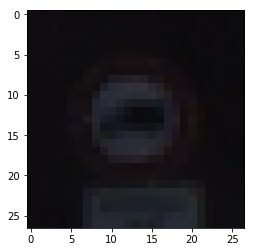

17 No entry


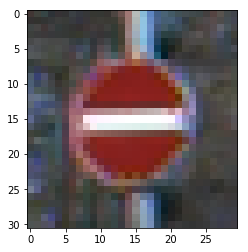

18 General caution


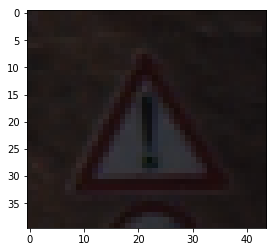

19 Dangerous curve to the left


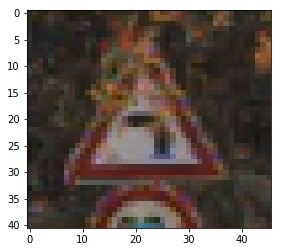

20 Dangerous curve to the right


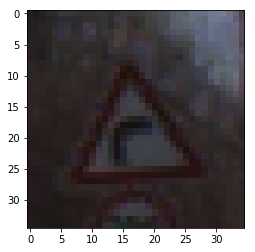

21 Double curve


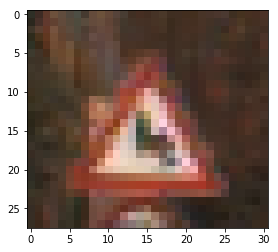

22 Bumpy road


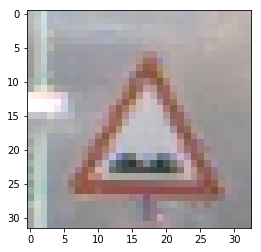

23 Slippery road


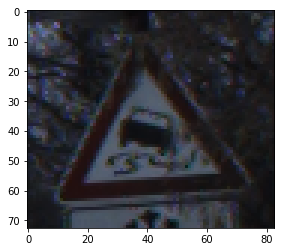

24 Road narrows on the right


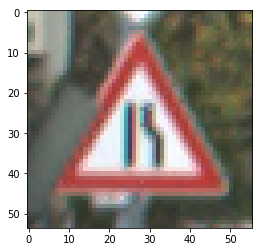

25 Road work


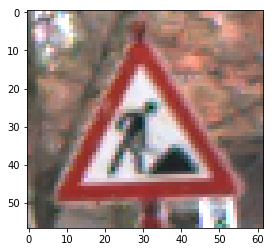

26 Traffic signals


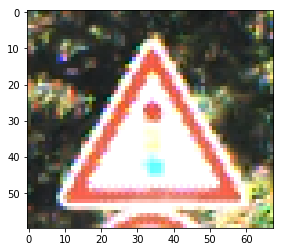

27 Pedestrians


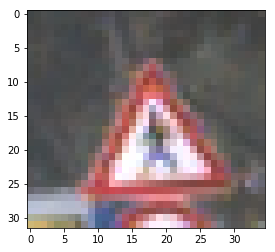

28 Children crossing


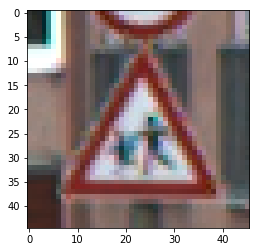

29 Bicycles crossing


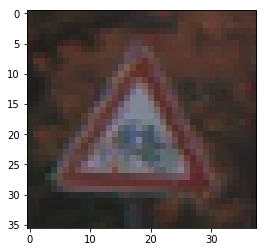

30 Beware of ice/snow


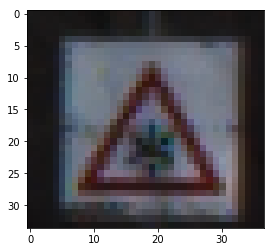

31 Wild animals crossing


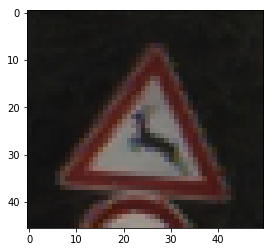

32 End of all speed and passing limits


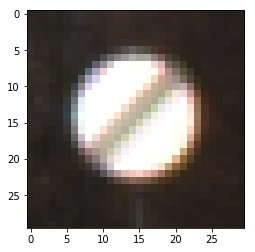

33 Turn right ahead


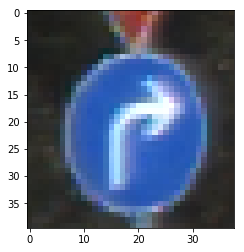

34 Turn left ahead


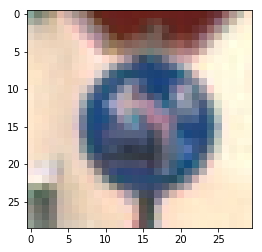

35 Ahead only


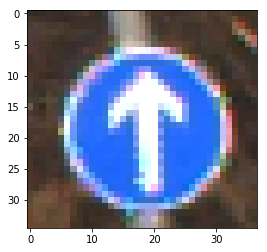

36 Go straight or right


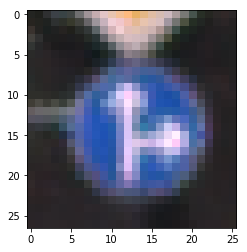

37 Go straight or left


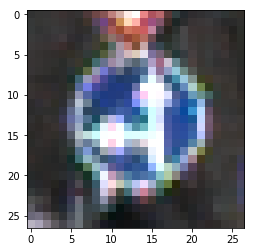

38 Keep right


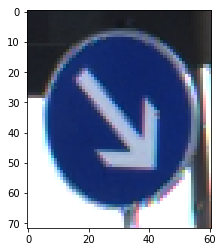

39 Keep left


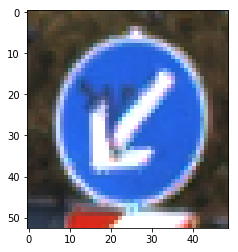

40 Roundabout mandatory


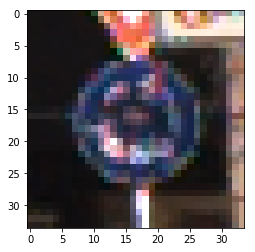

41 End of no passing


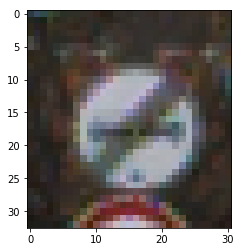

42 End of no passing by vechiles over 3.5 metric tons


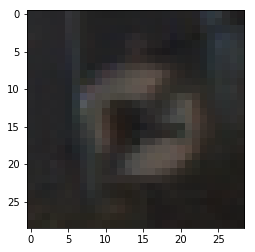

In [14]:
for label in sorted([l for l, c in label_counts], key=lambda p: int(data.classes[p])):
    i = [i for i, l in enumerate(y) if l == label][0]
    print(data.classes[y[i]], class_names[data.classes[y[i]]])
    plt.imshow(load_img_id(data.trn_ds, i, path))
    plt.show()

## Image sizes

In [1569]:
flags = cv2.IMREAD_UNCHANGED+cv2.IMREAD_ANYDEPTH+cv2.IMREAD_ANYCOLOR

folder = 'data/all/0'

files = os.listdir(folder)
sizes = []

for file in files:
    filename = os.path.join(folder, file)
    img = cv2.imread(filename, flags)
    sizes.append(max(img.shape[0], img.shape[1]))

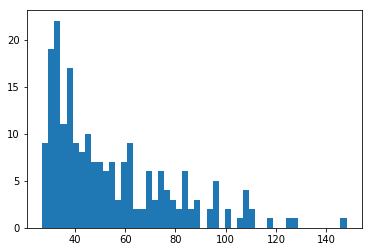

In [1573]:
plt.hist(sizes, bins=50)
plt.show()

# Image lighting

Let's try histogram equalization to improve constrast.

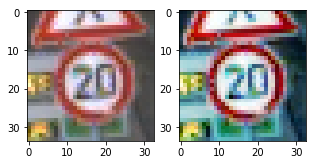

(34, 33, 3)


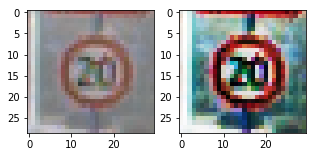

(29, 30, 3)


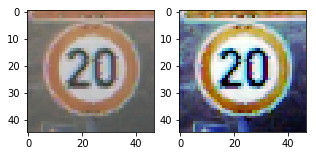

(45, 47, 3)


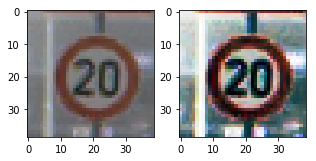

(39, 39, 3)


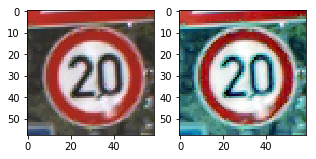

(58, 59, 3)


In [852]:
flags = cv2.IMREAD_UNCHANGED+cv2.IMREAD_ANYDEPTH+cv2.IMREAD_ANYCOLOR

folder = 'data/all/0'

files = os.listdir(folder)
for i in range(5):
    f = plt.figure(figsize=(5, 5))
    
    filename = os.path.join(folder, files[i])
    img = cv2.imread(filename, flags)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    sp = f.add_subplot(1, 2, 1)
    plt.imshow(img)
    
    img = np.concatenate([np.expand_dims(cv2.equalizeHist(img[:,:,i]), axis=2) for i in range(3)], axis=2)
    
    
    sp = f.add_subplot(1, 2, 2)
    plt.imshow(img)
    plt.show()
    
    print(img.shape)